# AUC and performande using Selected Peptides and Clinical DAta

In [6]:
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from os.path import join, dirname, abspath
import shap
import tqdm

In [11]:
important_peptides_and_clinical = pd.read_csv(join('..', 'Results', 'Top100_SHAP_peptides_and_clinical.csv')).rename(columns={'Unnamed: 0': 'Feature'})

In [12]:
important_peptides_and_clinical

,Feature,median_shap,std_error
0,twist_54214,0.594615,0.002565
1,smoking,0.303020,0.001889
2,twist_43798,0.299315,0.001538
3,twist_51296,0.215810,0.002543
4,agilent_9025,0.202593,0.001414
...,...,...,...
95,corona2_8998,0.001025,0.000207
96,agilent_11271,0.000033,0.000329
97,corona2_3330,0.000000,0.000000
98,corona2_3326,0.000000,0.000000


In [ ]:
metadata = pd.read_csv(join('..', 'Data', 'metadata.csv')).dropna()
metadata['sample_id'] = metadata['sample_id'].apply(lambda x: str(x).replace('.', '-'))

metadata.set_index('sample_id', inplace = True)
exist_data = pd.read_csv(join('..', 'Data', 'exist.csv'))
exist_data = exist_data.T 
exist_data.columns = exist_data.iloc[0]
exist_data = exist_data[1:]
### Combine metadata and PCA results
metadata_things = metadata[['sex', 'age', 'type_person', 'diagnosis', 'appendectomy', 'smoking']]


concat_pep_meta = pd.concat([metadata_things, exist_data], axis = 1)
def smoking(x):
    if x == 'Never':
        return 0
    elif x == 'Ex_smoker':
        return 1
    elif x == 'Current_smoker':
        return 2
    else:
        return np.nan
    
    
X = concat_pep_meta.copy()
X.drop(columns = ['type_person', 'diagnosis'], inplace = True)
# encoding
X['sex'] = X['sex'].apply(lambda x: 0 if x == 'Male' else 1)

X['appendectomy'] = X['appendectomy'].apply(lambda x: 0 if x == 'No' else 1)
X['smoking'] = X['smoking'].apply(lambda x: smoking(x))
X = X.astype('category')
y = concat_pep_meta['type_person']
y = y.apply(lambda x: 0 if x == 'Control' else 1)

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut, KFold
from sklearn.model_selection import StratifiedKFold
n_features = len(important_peptides_and_clinical)
dict_cross_val = {
    'mean_accuracy': [],
    'std_accuracy': [],
    'mean_roc_auc': [],
    'std_roc_auc': [],
}
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'seed': 100,
    'alpha': 0.2
}


for i in tqdm.tqdm(range(n_features)):
    names = important_peptides_and_clinical[:i+1]['Feature'].to_list()
    X_subset = X[names]
    cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)
    bst = XGBClassifier(**params, n_estimators=100, enable_categorical=True)
    scores = cross_val_score(bst, X_subset, y, cv=cv, scoring='accuracy', n_jobs=-1)
    dict_cross_val['mean_accuracy'].append(scores.mean())
    dict_cross_val['std_accuracy'].append(scores.std())
    scores_2 = cross_val_score(bst, X_subset, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    dict_cross_val['mean_roc_auc'].append(scores_2.mean())
    dict_cross_val['std_roc_auc'].append(scores_2.std())

100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Text(0, 0.5, 'Mean RUC AUC')

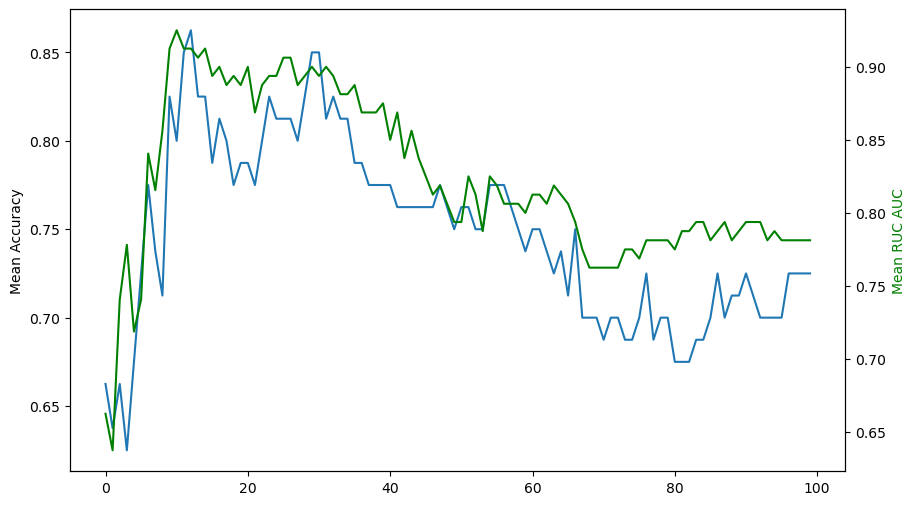

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dict_cross_val['mean_accuracy'])
ax.set_ylabel('Mean Accuracy')
axt = ax.twinx()
axt.plot(dict_cross_val['mean_roc_auc'], color = 'green')
axt.set_ylabel('Mean RUC AUC', color = 'green')

In [39]:
dict_cross_val['n_features'] = list(range(1, n_features + 1))
cross_val_df = pd.DataFrame(dict_cross_val)
# features = median_importance.index[:50].to_list()
cross_val_df.sort_values(by='mean_roc_auc', ascending=False, inplace=True)
n_features_optimal = cross_val_df.iloc[0]['n_features'].astype(int)
opt_features = important_peptides_and_clinical[:n_features_optimal]['Feature'].to_list()
print(f'Optimal number of features: {n_features_optimal}')
print(f'Optimal features: {opt_features}')

Optimal number of features: 11
Optimal features: ['twist_54214', 'smoking', 'twist_43798', 'twist_51296', 'agilent_9025', 'twist_54947', 'agilent_242591', 'agilent_8318', 'agilent_241665', 'twist_46426', 'agilent_6936']


In [40]:
cross_val_df

,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,n_features
10,0.8000,0.139194,0.925000,0.087500,11
9,0.8250,0.127475,0.912500,0.084779,10
14,0.8250,0.150000,0.912500,0.112500,15
12,0.8625,0.103833,0.912500,0.097628,13
11,0.8500,0.134629,0.912500,0.101550,12
...,...,...,...,...,...
5,0.7250,0.134629,0.740625,0.183313,6
2,0.6625,0.168170,0.740625,0.235124,3
4,0.6750,0.178536,0.718750,0.189572,5
0,0.6625,0.209538,0.662500,0.209538,1


In [65]:
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.metrics import roc_curve, auc
# LOO CV with optimal features

X_opt = X[opt_features]
y = y.copy()

cv = StratifiedKFold(n_splits = 39, shuffle=True, random_state=42)  
y_true = []
y_pred_proba = []
# make a loo cv
for train_index, test_index in cv.split(X_opt, y):
    X_train, X_test = X_opt.iloc[train_index], X_opt.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # print(test_index)
    model = XGBClassifier(**params, n_estimators=200, enable_categorical=True)
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:,1]
    y_true.extend(y_test)
    y_pred_proba.extend(y_prob)
    # fpr, tpr, thresholds = roc_curve(y_train, y_prob)



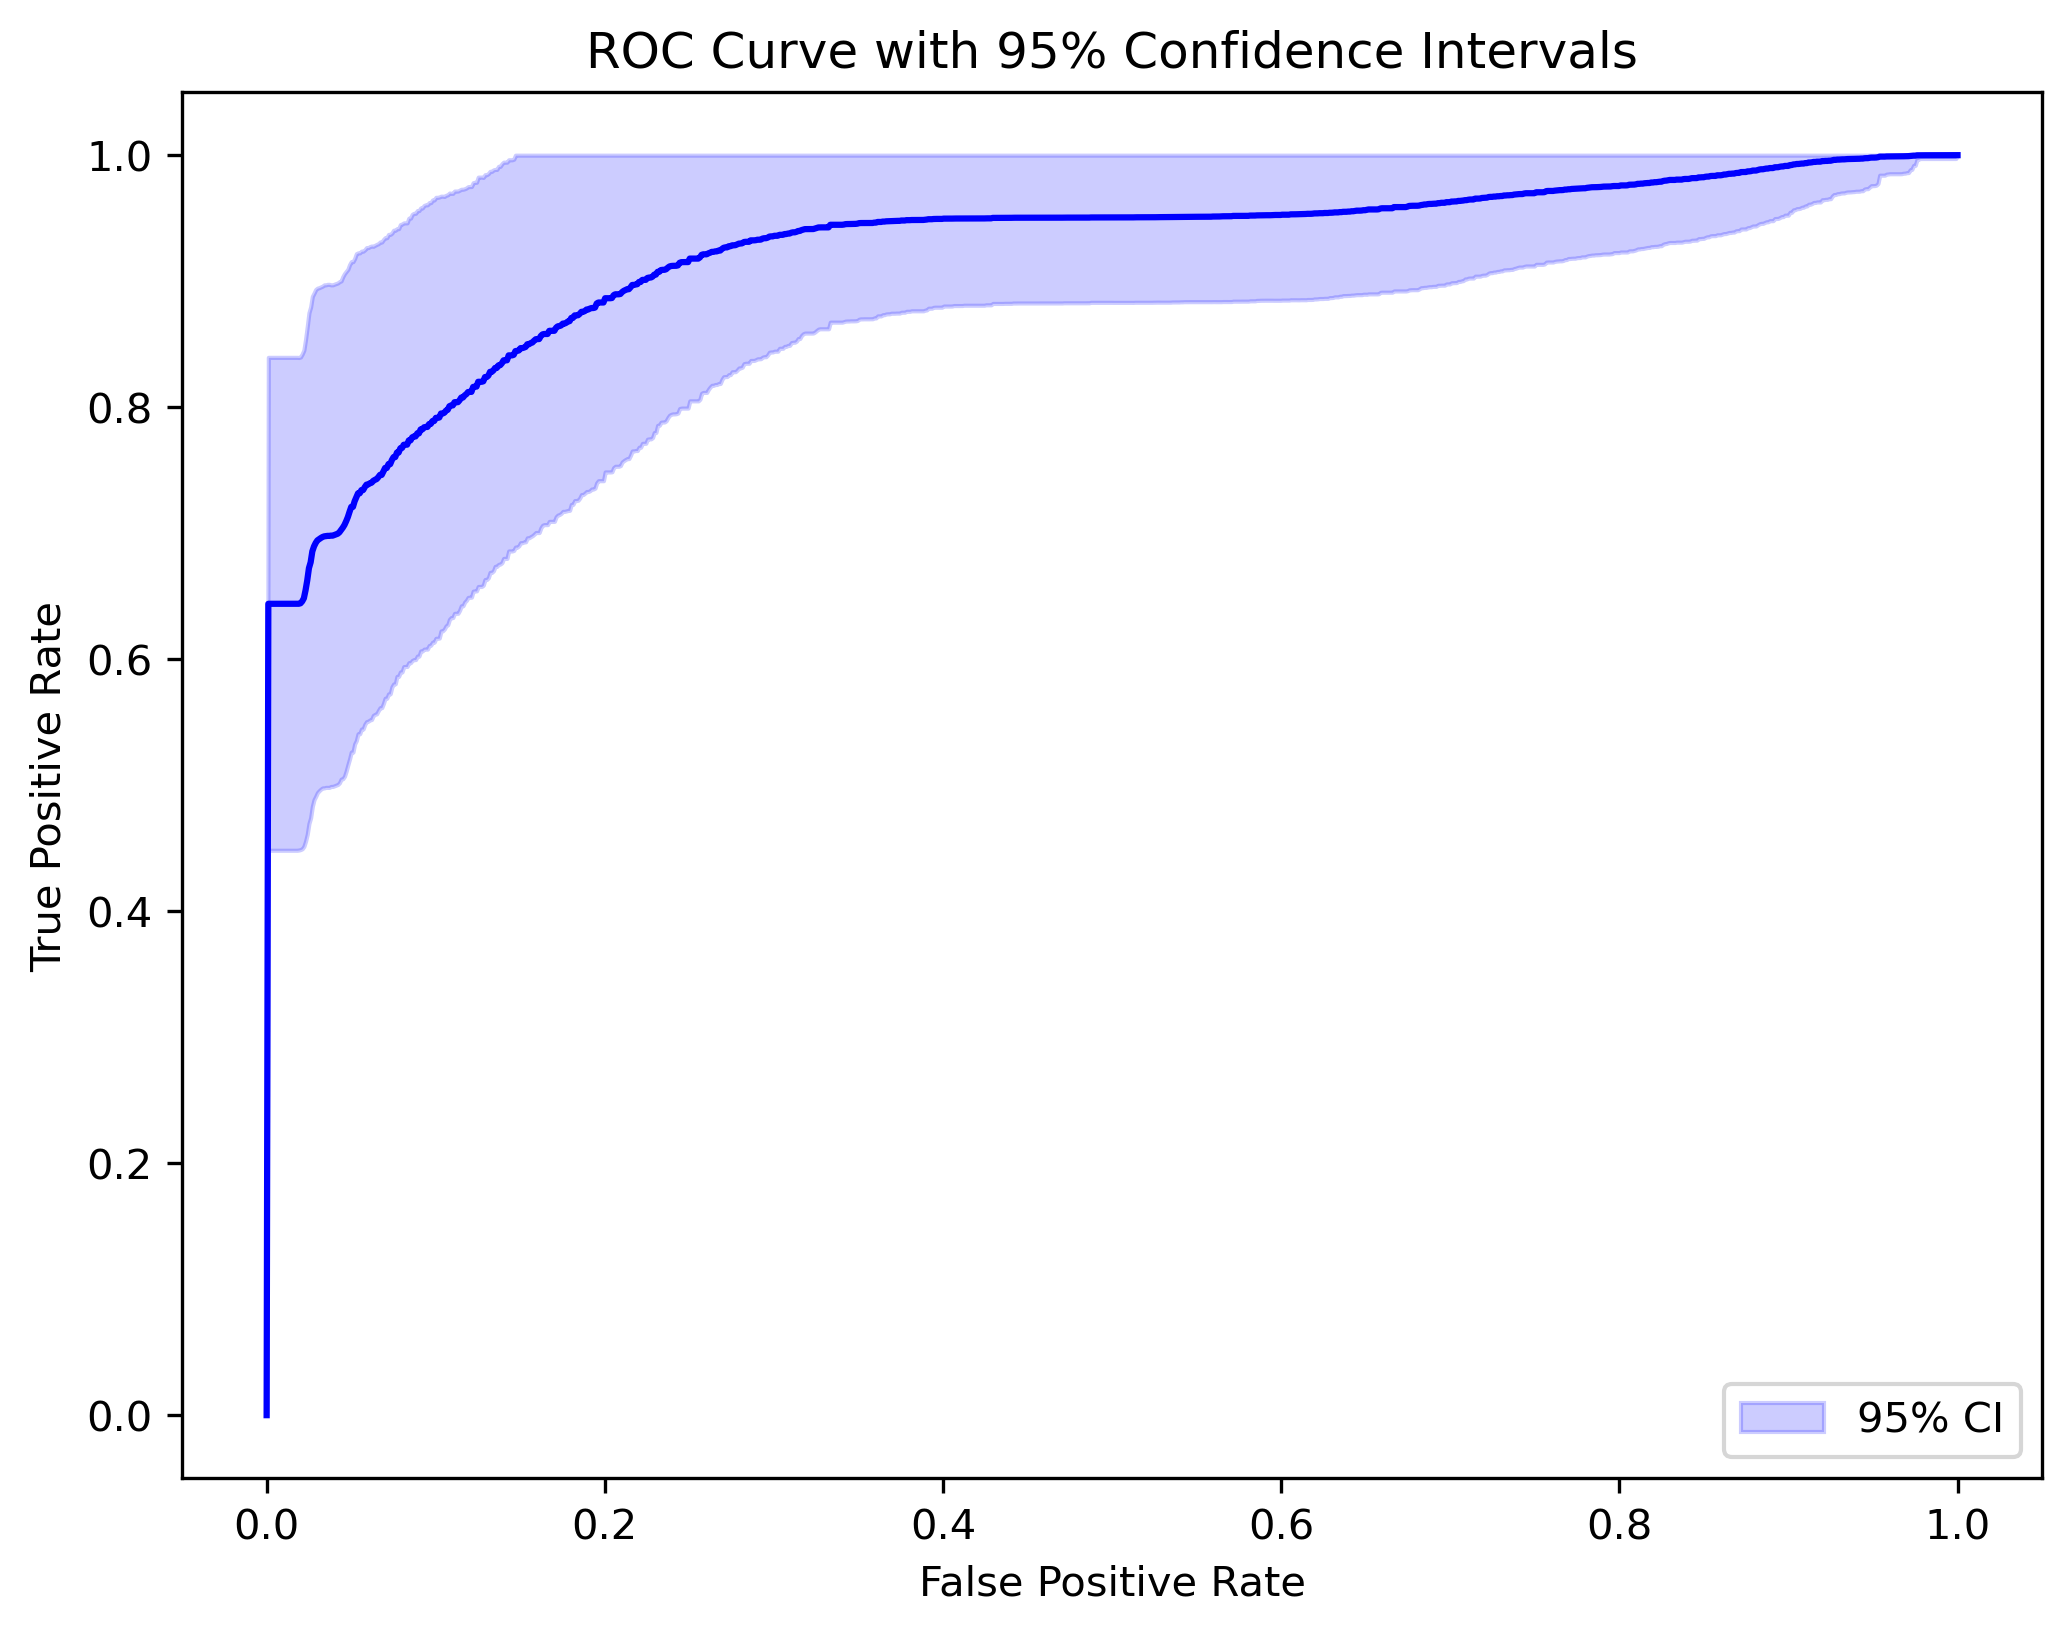

In [66]:
indexes = np.arange(len(y_pred_proba))

samples_indexes = np.random.choice(
    indexes, size=[1000,80], replace=True
)

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

fprs = []
tprs = []
for indexes in samples_indexes:
    fpr, tpr , _ = roc_curve(y_true[indexes.astype(int)], y_pred_proba[indexes.astype(int)])
    fprs.append(fpr)
    tprs.append(tpr)
    # plt.plot(fpr, tpr, color='blue', alpha=0.1)
    
fpr_mean    = np.linspace(0, 1, 1000)
interp_tprs = []
for i in range(1000):
    fpr           = fprs[i]
    tpr           = tprs[i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = 1.96*np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std

plt.figure(figsize=(8, 6), dpi = 300)
plt.plot(fpr_mean, tpr_mean, color='blue', alpha=1.0)
plt.fill_between(fpr_mean, tpr_lower, tpr_upper, color='blue', alpha=0.2, label = '95% CI')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with 95% Confidence Intervals')
plt.legend()

# SHAP

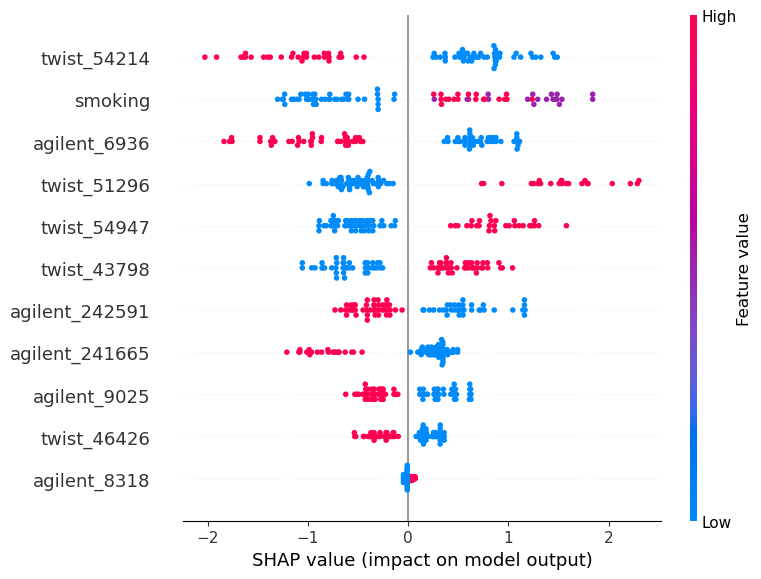

In [42]:
# shap training
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

X_subset = X[opt_features]


bst = XGBClassifier(
    **params, n_estimators=100, enable_categorical=True
)
bst.fit(X_subset, y)
    
shap_values = shap.TreeExplainer(bst).shap_values(X_subset)

shap.summary_plot(shap_values, X_subset.astype('float64'))

# Table

In [24]:
peptide_info = pd.read_csv(join('..','Data', 'peptide_libraries_info.csv'))

In [51]:
shap_values_pd = pd.DataFrame(shap_values, columns=X_subset.columns)
abs_shap_values = shap_values_pd.abs().mean(axis = 0)
subset_metadata = X_subset.copy()
subset_metadata['type_person'] = y.values


control = subset_metadata[subset_metadata['type_person'] == 0].drop(columns=['type_person']).astype(int)
control['smoking'] = [0 if x == 0 else 1 for x in control['smoking']]
ibd = subset_metadata[subset_metadata['type_person'] == 1].drop(columns=['type_person']).astype(int)    
ibd['smoking'] = [0 if x == 0 else 1 for x in ibd['smoking']]
# ods_control
ods_control = control.mean(axis = 0)
ods_ibd = ibd.mean(axis = 0)

# ods_ratio
ods_ratio = np.log(ods_ibd / ods_control)


# peptides_important

# add columns for smoking with nothing int
peptides_important = peptide_info.set_index('peptide_name')
peptides_important.loc['smoking'] = 0

peptides_important = peptides_important.loc[opt_features]

position = peptides_important['pos']
len_seq = peptides_important['len_seq']
description_pep = peptides_important['Description']
specie = peptides_important['species']

table = pd.DataFrame({
    'Position': position,
    'Length': len_seq,
    'Description': description_pep,
    'Species': specie,
    'mean_abs_shap': abs_shap_values,
    '%Control': ods_control,
    '%IBD': ods_ibd,
    'log(ods_ratio)': ods_ratio
})  

In [53]:
table.to_csv(join('..', 'Results', 'SHAP_selected_peptides_clinical_table_results.csv'))

In [52]:
table

,Position,Length,Description,Species,mean_abs_shap,%Control,%IBD,log(ods_ratio)
twist_54214,204,2164.0,polyprotein,Rhinovirus A,0.907828,0.550,0.225,-0.893818
smoking,0,0,0,0,0.860991,0.325,0.625,0.653926
twist_43798,0,245.0,BZLF1,Lymphocryptovirus humangamma4,0.571790,0.400,0.625,0.446287
twist_51296,714,992.0,EBNA3C latent protein,Lymphocryptovirus humangamma4,0.810808,0.175,0.400,0.826679
agilent_9025,44,1039.0,Bvh-3,Streptococcus pneumoniae,0.349053,0.675,0.375,-0.587787
twist_54947,816,NaN,Rhinovirus B Genome polyprotein,Rhinovirus B,0.665618,0.250,0.450,0.587787
agilent_242591,836,905.0,Heme/hemopexin-binding protein,Haemophilus influenzae,0.480099,0.675,0.425,-0.462624
agilent_8318,395,NaN,Epstein-Barr nuclear antigen 1,Lymphocryptovirus humangamma4,0.023230,0.150,0.325,0.773190
agilent_241665,264,437.0,Immunoglobulin-binding protein Sbi,Staphylococcus aureus,0.439947,0.425,0.125,-1.223775
twist_46426,433,487.0,nuclear protein EBNA2,Lymphocryptovirus humangamma4,0.241007,0.525,0.300,-0.559616


In [46]:
peptides_important.loc['smoking']

aa_seq              0
pos                 0
len_seq             0
full name           0
Description         0
is_IEDB_or_cntrl    0
is_auto             0
is_infect           0
is_EBV              0
is_toxin            0
is_PNP              0
is_EM               0
is_MPA              0
is_patho            0
is_probio           0
is_IgA              0
is_flagellum        0
signalp6_slow       0
is_topgraph_new     0
is_allergens        0
domain              0
kingdom             0
phylum              0
class               0
order               0
family              0
genus               0
species             0
common              0
Name: smoking, dtype: object

In [50]:
control

,twist_54214,smoking,twist_43798,twist_51296,agilent_9025,twist_54947,agilent_242591,agilent_8318,agilent_241665,twist_46426,agilent_6936
R33P01_01_N003_IBD-Chile_A_T_C2,0,0,1,0,0,0,1,0,0,1,1
R33P01_02_N006_IBD-Chile_A_T_C2,0,0,0,1,1,0,1,0,1,1,1
R33P01_03_N008_IBD-Chile_A_T_C2,1,0,0,0,0,1,1,0,0,0,0
R33P01_04_N011_IBD-Chile_A_T_C2,0,0,0,0,1,0,1,0,1,0,0
R33P01_05_N013_IBD-Chile_A_T_C2,1,0,0,0,0,0,0,0,0,0,0
R33P01_06_N014_IBD-Chile_A_T_C2,1,0,0,0,0,0,1,0,0,0,0
R33P01_07_N015_IBD-Chile_A_T_C2,0,0,1,0,1,0,0,0,0,1,1
R33P01_08_N018_IBD-Chile_A_T_C2,0,2,0,0,0,0,1,0,0,1,0
R33P01_09_N020_IBD-Chile_A_T_C2,0,2,0,0,1,0,1,0,0,1,1
R33P01_10_N021_IBD-Chile_A_T_C2,0,2,1,0,1,0,1,0,0,1,1
